# This is a Notebook that is a demo Notebook for WinsorCAM on PascalVOC 2012 images

## Imports

In [2]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, show

from torchvision.transforms import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch
from torch import nn

import os
import random
import numpy as np
import torch
import os
import shutil

import imageio.v2 as imageio
from PIL import Image
from tqdm import tqdm
from skimage import filters
from utils import *
from winsorcam import *


## Data Loading

In [3]:
pascal_voc_classes = {
    "[0, 0, 0]": ("background", 0),
    "[128, 0, 0]": ("aeroplane", 1),
    "[0, 128, 0]": ("bicycle", 2),
    "[128, 128, 0]": ("bird", 3),
    "[0, 0, 128]": ("boat", 4),
    "[128, 0, 128]": ("bottle", 5),
    "[0, 128, 128]": ("bus", 6),
    "[128, 128, 128]": ("car", 7),
    "[64, 0, 0]": ("cat", 8),
    "[192, 0, 0]": ("chair", 9),
    "[64, 128, 0]": ("cow", 10),
    "[192, 128, 0]": ("diningtable", 11),
    "[64, 0, 128]": ("dog", 12),
    "[192, 0, 128]": ("horse", 13),
    "[64, 128, 128]": ("motorbike", 14),
    "[192, 128, 128]": ("person", 15),
    "[0, 64, 0]": ("pottedplant", 16),
    "[128, 64, 0]": ("sheep", 17),
    "[0, 192, 0]": ("sofa", 18),
    "[128, 192, 0]": ("train", 19),
    "[0, 64, 128]": ("tvmonitor", 20)
}


classes = [x[0] for x in pascal_voc_classes.values()][1:]
print(classes)

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [ ]:

class SimpleDataset(Dataset):
    def __init__(self, data_folder, transforms_image=None, transforms_label=None, pascal_voc_classes=None):
        self.data_folder = data_folder
        self.transforms_image = transforms_image
        self.transforms_label = transforms_label
        self.pascal_voc_classes= pascal_voc_classes
        # List all image names (without extension) in jpg_images
        self.image_names = [os.path.splitext(f)[0] for f in os.listdir(os.path.join(self.data_folder, "jpg_images")) if f.endswith(".jpg")]
        
        # Create a mapping from image names to indices for efficient lookup
        self.name_to_index = {name: idx for idx, name in enumerate(self.image_names)}

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, key):
        # Support both integer indices and filenames
        if isinstance(key, int):
            # Traditional index-based access
            image_name = self.image_names[key]
        elif isinstance(key, str):
            # Filename-based access
            # Remove extension if provided
            image_name = os.path.splitext(key)[0]
            if image_name not in self.name_to_index:
                raise KeyError(f"Image '{key}' not found in dataset. Available images: {list(self.name_to_index.keys())[:10]}...")
        else:
            raise TypeError(f"Key must be int or str, got {type(key)}")
        
        image_path = os.path.join(self.data_folder, "jpg_images", image_name + ".jpg")
        label_path = os.path.join(self.data_folder, "masks", image_name + ".png")
        
        # Check if files exist
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")
        if not os.path.exists(label_path):
            raise FileNotFoundError(f"Label file not found: {label_path}")
        
        image = Image.open(image_path)
        label = Image.open(label_path)
        
        if self.transforms_image:
            image = self.transforms_image(image)
        if self.transforms_label:
            label = self.transforms_label(label)
        
        # Fast class detection and one-hot encoding
        class_info = self._get_class_from_label(label)
        one_hot = torch.zeros(len(self.pascal_voc_classes), dtype=torch.float32)
        if class_info is not None:
            one_hot[class_info[1]] = 1.0
        return image, label, one_hot, class_info[0]
    

    def _get_class_from_label(self, label):
        """Fast class detection from label tensor"""
        # Get unique colors efficiently
        pixel_colors = label.view(-1, 3)
        unique_colors = torch.unique(pixel_colors, dim=0)
        
        # Convert to tuples and find non-background class
        for color in unique_colors:
            rgb_tuple = tuple(color.int().tolist())
            if rgb_tuple != (0, 0, 0):  # Skip background
                rgb_str = str(list(rgb_tuple))
                if rgb_str in self.pascal_voc_classes:
                    return self.pascal_voc_classes[rgb_str]
        return None
    def get_available_images(self):
        """Return list of available image names"""
        return self.image_names.copy()
    
# make a transform
# (transform_image and transform_label already defined in previous cells)

def denormalize(tensor):
    # denormalize the tensor
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return tensor

transform_image = transforms.Compose([
    transforms.Resize((224 , 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_label = transforms.Compose([
    transforms.Resize((224 , 224 ), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda x: x.convert("RGB") if x.mode == "P" else x),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255),  # Scale to 0-255 if needed
    transforms.Lambda(lambda x: x.long()),  # Convert to long if class indices
    transforms.Lambda(lambda x: fix_label(x))
])


def fix_label(label):
    """
    Function to fix the labels to be 0 for background and 1 for object
    """
    label = label.permute(1, 2, 0)
    label_mask = (label == torch.tensor([224 , 224 , 192])).all(dim=-1)
    label[label_mask] = torch.tensor([0, 0, 0])
    
    return label

data_folder = "./simple_pascal_voc_dataset"
# data_folder already defined
dataset = SimpleDataset(data_folder, transforms_image=transform_image, transforms_label=transform_label, pascal_voc_classes=pascal_voc_classes)

print(dataset.get_available_images())    


    

['dog', 'car', 'cat', 'bicycle', 'horse', 'plane', 'train', 'bottle']


## This is a very initial UI test to show the WinsorCAM on PascalVOC 2012 images

In [5]:
from UI import pascal_voc_controller

# Launch the Pascal VOC UI controller
pascal_voc_controller(dataset, classes, image_width=224)


## Other visualizations

### This code sets different parameters for the WinsorCAM and how things are visualized

The values you set here will affect many of the later visualizations and outputs.

In [6]:
from utils import create_winsorgradcam_model
# ===== MODEL SELECTION =====
# Select which model architecture to use
SELECTED_MODEL = 'densenet121'  # Options: 'resnet50', 'densenet121', 'vgg16', 'inception_v3', 'efficientnet_b0', 'convnext_tiny'
cpu_only = False  # Set to True if you want to force CPU usage
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the selected model with UniversalGradCAM wrapper (from universal_gradcam.py)
# This now returns inception_flag to indicate if we need 299x299 input size
model, layer_names, inception = create_winsorgradcam_model(
    SELECTED_MODEL, 
    device=device.type, 
    num_classes=20,
    cpu_only_flag=cpu_only
)

print(f"Loaded model: {SELECTED_MODEL}")
print(f"Number of convolutional layers: {len(layer_names)}")
print(f"Inception model (299x299 input): {inception}")
print(f"Layer names are prefixed with 'model.' by UniversalGradCAM")
print(f"Example layers: {layer_names[:3]}")

# if inception is True, we need to change the input size
if inception:
    dataset.transforms_image.transforms[0] = transforms.Resize((299 , 299))
    dataset.transforms_label.transforms[0] = transforms.Resize((299 , 299 ), interpolation=transforms.InterpolationMode.NEAREST)
else:
    dataset.transforms_image.transforms[0] = transforms.Resize((224 , 224))
    dataset.transforms_label.transforms[0] = transforms.Resize((224 , 224 ), interpolation=transforms.InterpolationMode.NEAREST)


# It is possible to change what class index to do backpropagation on but it is not recommended unless you understand the process
class_index = None

# There have been tests on aggregation methods for individual kernels but the common is to use the mean (as it is in the original Grad-CAM paper)
gradient_aggregation_method = "mean"
# This tells the method how to aggregate the importances from the entire layer
# it is most common to use either "mean" or "max"
layer_aggregation_method = "mean"
# This tell the method how to aggregate the Grad-CAM maps found from all the layers in the model
## It is most common to use weighted as this is the WinsorCAM way
## If one wanted to see the naive Grad-CAM maps averaged together they could use "mean"
stack_aggregation_method = "weighted"
stack_relu = True  # Whether or not to apply ReLU to layer importance

# This is the percentile to use for Winsorization
## This only impacts the visualizations that have a set percentile (as opposed to the ones that calculate on a range of percentiles)
### Value between 0 and 100
winsor_percentile = 90

# These are interpolation modes for the heatmaps
## I usually use bilinear with a colormap of "nipy_spectral" for the final visualization
## If nearest-exact is it is best visualized with a colormap of "Reds" 
### Other colormaps can be used if you want to experiment
interpolation_mode = "bilinear"
map_color = "nipy_spectral"

# interpolation_mode = "nearest-exact"
# map_color="Reds"

# This changes the opacity of the heatmap that is overlayed on the image
# at 1 the heatmap will be made very apparent and at 0 the heatmaps will not be visible
map_opacity_multiplier = .7

# This selects the device to use for the model
## If you like you could change this
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Select which image to visualize - you can use either:
# - String keys: "dog", "eagle", "fish1", "fish2", "owl", "zebra"
# - Integer indices: 0, 1, 2, 3, 4, 5
image_name = "plane"  # Try: 'horse', 'cat', 'plane', 'bottle', 'train', 'dog', 'car', 'bicycle'

Using device: cuda
Loaded model: densenet121
Number of convolutional layers: 120
Inception model (299x299 input): False
Layer names are prefixed with 'model.' by UniversalGradCAM
Example layers: ['model.features.conv0', 'model.features.denseblock1.denselayer1.conv1', 'model.features.denseblock1.denselayer1.conv2']


#### Showing every layer of a model's GradCAM to see how it change layer to layer via GIF

In [7]:
layer_gif_name = "./outputs/gradcam_layers.gif"
temp_dir = "./temp"

In [8]:
input_tensor, label, one_hot, indx = dataset[image_name]
# First run YOUR implementation (with fresh hooks)
model = model.to(device)
model.storage.clear()  # Ensure storage is clear
model._unregister_hooks()  # Remove any existing hooks
model._register_hooks()    # Register fresh hooks

model.eval()
with torch.no_grad():
    output = model(input_tensor.to(device).unsqueeze(0))
predicted_class = torch.argmax(output).item()
sample_label = torch.argmax(one_hot).item()
print(f"Predicted class: {predicted_class}")
print(f"predicted class name:{classes[predicted_class]}")
# print(f"Sample label: {sample_label}")
# raise ValueError("Stop here")
# print(labels)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
unnormalized_image = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
unnormalized_image = std * unnormalized_image + mean
unnormalized_image = np.clip(unnormalized_image, 0, 1)
# print(f"actual label: {labels[sample_label]}")
# print(f"predicted label: {labels[predicted_class]}")

model.storage.clear()  # Ensure storage is clear
model._unregister_hooks()  # Remove any existing hooks
model._register_hooks()    # Register fresh hooks

# use get_gradcams_and_importance
stacked_gradcam, gradcams, _ = model.get_gradcams_and_importance(input_tensor.to(device).unsqueeze(0),
                                                                                 predicted_class, layer_names,
                                                                                 gradient_aggregation_method,
                                                                                 layer_aggregation_method, True,
                                                                                 interpolation_mode=interpolation_mode)



# resize the stacked gradcam to the size of the input tensor
# Add batch and channel dimensions: (N=1, C=120, H, W)
stacked_gradcam_resized = F.interpolate(
    stacked_gradcam.unsqueeze(0),  # (1, 120, H, W)
    size=input_tensor.shape[1:], 
    mode=interpolation_mode
).squeeze(0)  # (120, 224, 224)
stacked_gradcam = stacked_gradcam_resized


temp_dir = "./temp"

# Create a directory to store the images
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# get the length of the gradcams
num_layers = stacked_gradcam.shape[0]
loading_bar = tqdm(total=num_layers, desc="Generating GradCAM images", unit="layer")
try:
    plt.ioff()
    for i in range(num_layers):
        gradcam_np = stacked_gradcam[i].cpu().numpy()
        plt.figure()
        plt.imshow(unnormalized_image)
        plt.imshow(create_colored_heatmap(gradcam_np, size=input_tensor.shape[1:], colormap=map_color, op_multiplier=map_opacity_multiplier, interpolation_mode=interpolation_mode), alpha=map_opacity_multiplier)
        plt.title(f"Layer {i}")
        plt.axis('off')
        plt.savefig(f"{temp_dir}/gradcam_layer_{i}.png", bbox_inches='tight', pad_inches=0)
        plt.close()
        loading_bar.update(1)
finally:
    plt.ion()  # Re-enable interactive mode
    loading_bar.close()


try:
    with imageio.get_writer(layer_gif_name, mode='I', duration=2000, loop=0) as writer:
        for i in range(num_layers):
            image_file = os.path.join(temp_dir, f"gradcam_layer_{i}.png")
            if os.path.exists(image_file):
                image = imageio.imread(image_file)
                writer.append_data(image)
                del image  # Free memory immediately
    print(f"GIF saved to {layer_gif_name}")
finally:
    # delete the temporary dir
    shutil.rmtree(temp_dir)



Predicted class: 0
predicted class name:aeroplane


Generating GradCAM images: 100%|████████████████████████████| 120/120 [00:23<00:00,  5.07layer/s]


GIF saved to ./outputs/gradcam_layers.gif


#### Showing Winsor-CAM is compared to Grad-CAM on final layer vs. mean of all layers

Predicted class: 0
predicted class name:aeroplane
shapes: image (224, 224, 3), mask torch.Size([224, 224])


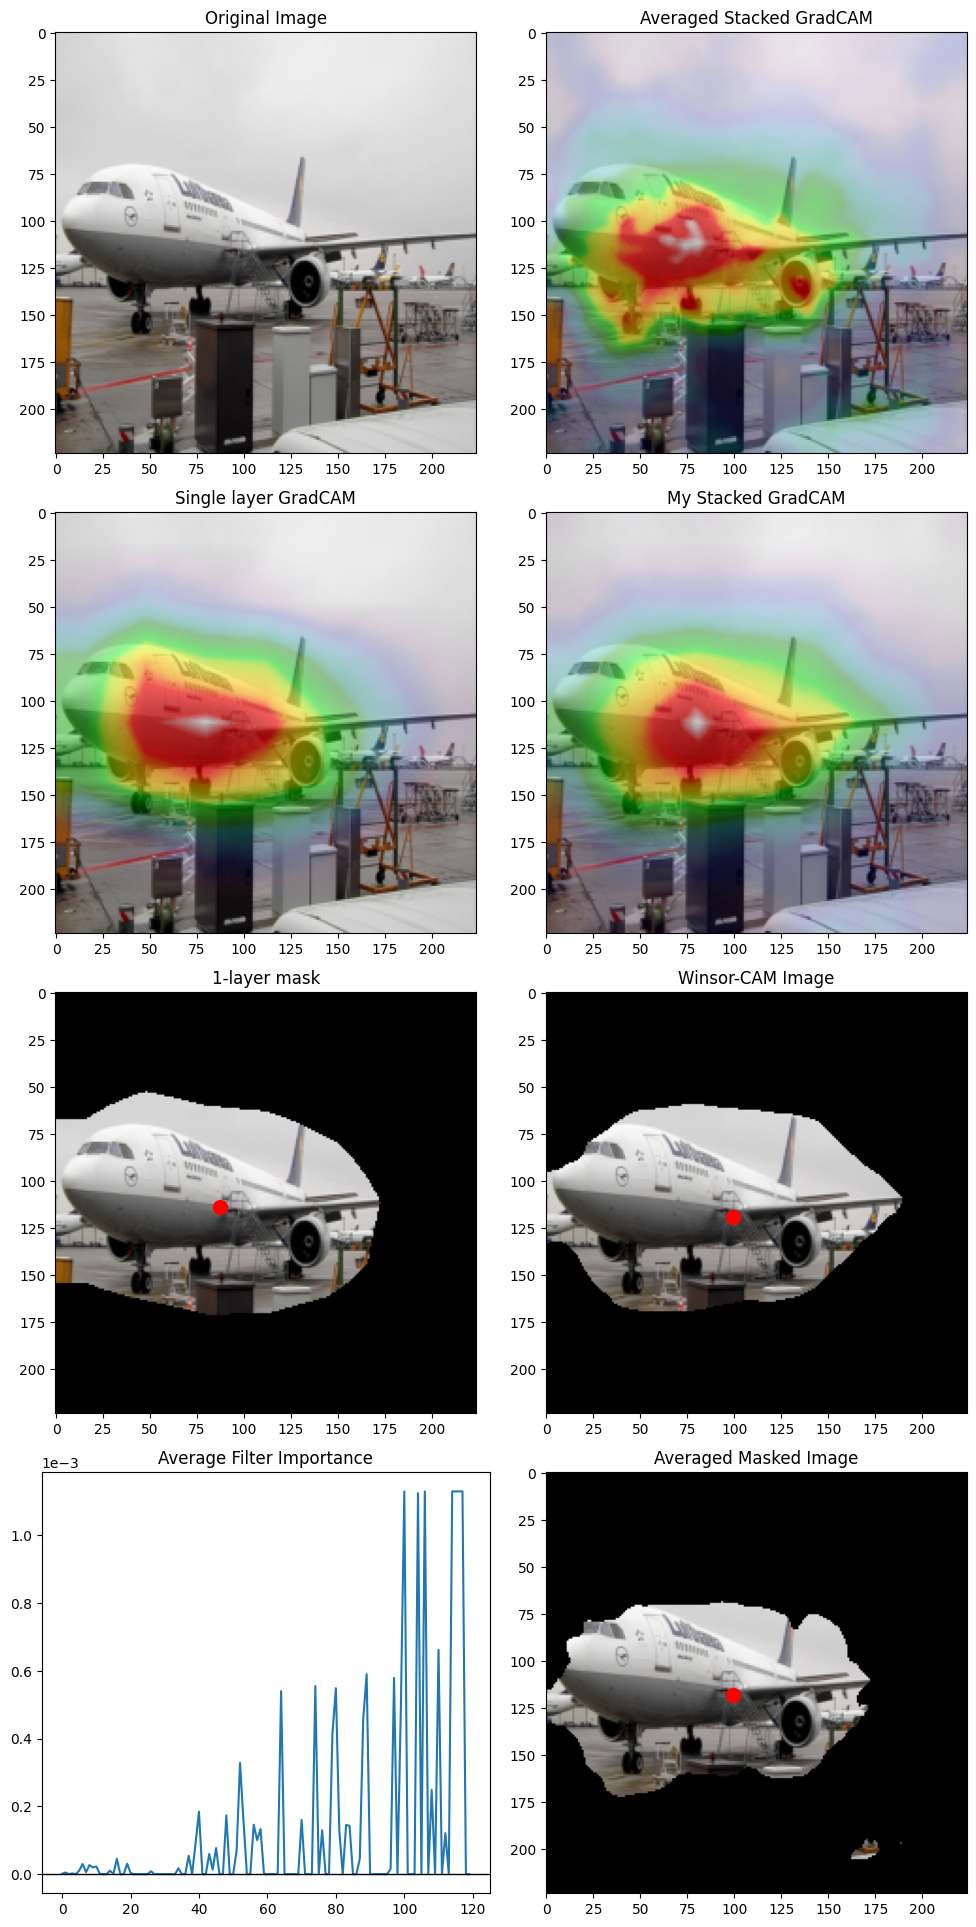

In [9]:
save_path="./outputs/gradcam_visualization.png"

def show_gradcam(model, dataset, image_name, class_index,
                 layer_names, gradient_aggregation_method,
                 layer_aggregation_method, 
                 stack_relu, winsor_percentile,
                 interpolation_mode='nearest', labels = None,
                 map_color = "Reds", map_opacity_multiplier = .9,
                 save_path="./outputs/gradcam_visualization.png"):

    input_tensor, label, one_hot, indx = dataset[image_name]
    input_tensor = input_tensor.unsqueeze(0).to(device)
    model = model.to(device)
    
    
    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks
    
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    predicted_class = torch.argmax(output).item()
    sample_label = torch.argmax(one_hot).item()
    print(f"Predicted class: {predicted_class}")
    print(f"predicted class name:{classes[predicted_class]}")


    
    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks

    
    stacked_gradcam, gradcams, importance_tensor = model.get_gradcams_and_importance(input_tensor.to(device),
                                                        predicted_class, layer_names,
                                                        gradient_aggregation_method,
                                                        layer_aggregation_method, stack_relu,
                                                        interpolation_mode=interpolation_mode)
    


    winsor_gradcam, grads = model.winsorize_stacked_gradcam(input_tensor, stacked_gradcam, 
                                                       importance_tensor, 
                                                       interpolation_mode=interpolation_mode, 
                                                       winsor_percentile=winsor_percentile)
    

    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks
    

    
    # Reshape all gradcams to the size of the image
    # heatmap = [F.interpolate(gradcam.unsqueeze(0).unsqueeze(0), size=input_tensor.shape[2:], mode=interpolation_mode).squeeze(0).squeeze(0) for gradcam in gradcams]
    # Now stack the gradcams
    # heatmap = torch.stack(gradcams, dim=0)
    # Take the mean of the gradcams
    heatmap= torch.mean(stacked_gradcam, dim=0)
    heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), size=input_tensor.shape[2:], mode=interpolation_mode).squeeze(0).squeeze(0)


    # I need to have a grid of images
    # 6 images in 2 columns and 4 rows
    # make the grid

    #make the grid
    fig, axs = plt.subplots(4, 2, figsize=(10, 20))
    # Unnormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnormalized_image = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    unnormalized_image = std * unnormalized_image + mean
    unnormalized_image = np.clip(unnormalized_image, 0, 1)

    plt.subplot(4, 2, 1)
    plt.imshow(unnormalized_image)
    plt.title("Original Image")

    plt.subplot(4, 2, 2)

    # show the image
    plt.imshow(unnormalized_image)
    plt.imshow(create_colored_heatmap(heatmap.squeeze(), size=input_tensor.shape[2:], colormap=map_color, op_multiplier=map_opacity_multiplier, interpolation_mode=interpolation_mode))
    plt.title("Averaged Stacked GradCAM")


    plt.subplot(4, 2, 4)
    # # show the gradcam_color
    plt.imshow(unnormalized_image, alpha=1)
    # print the min and max of the gradcam
    plt.imshow(create_colored_heatmap(winsor_gradcam, size=input_tensor.shape[2:], op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
    plt.title("My Stacked GradCAM")



    plt.subplot(4, 2, 3)
    plt.imshow(unnormalized_image, alpha=1)
    # normalize the gradcam[-1]
    plt.imshow(create_colored_heatmap(gradcams[-1], size=input_tensor.shape[2:], op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
    plt.title("Single layer GradCAM")


    plt.subplot(4, 2, 4)
    # # show the gradcam_color
    plt.imshow(unnormalized_image, alpha=1)
    # print the min and max of the gradcam
    plt.imshow(create_colored_heatmap(winsor_gradcam, size=input_tensor.shape[2:], op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
    plt.title("My Stacked GradCAM")



    plt.subplot(4, 2, 7)

    plt.plot(grads.cpu().numpy())
    # on the y axis use scientific notation
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    # put a line at 0
    plt.axhline(0, color='black', lw=1)
    plt.title("Average Filter Importance")


    stacked_gradcam_np = winsor_gradcam.cpu().numpy()
        
    # Generate masked image
    masked_image = generate_masked_image(unnormalized_image, stacked_gradcam_np)
    # insert the centroid of the heatmap
    plt.subplot(4, 2, 5)

    print(f"shapes: image {unnormalized_image.shape}, mask {stacked_gradcam[-1].shape}")

    their_mask = generate_masked_image(unnormalized_image, stacked_gradcam[-1])

    plt.imshow(their_mask)
    # reshape the gradcam to the size of the image
    # resized = F.interpolate(stacked_gradcam_np[-1], size=input_tensor.shape[2:], mode=interpolation_mode).squeeze()
    plt.scatter(*find_heatmap_centroid(stacked_gradcam[-1]), color='red', s=100)
    plt.title("1-layer mask")



    plt.subplot(4, 2, 6)
    plt.imshow(masked_image)
    plt.scatter(*find_heatmap_centroid(winsor_gradcam), color='red', s=100)
    plt.title("Winsor-CAM Image")


    # their mask

    their_mask = generate_masked_image(unnormalized_image, heatmap.squeeze())
    plt.subplot(4, 2, 8)
    plt.imshow(their_mask)
    plt.scatter(*find_heatmap_centroid(heatmap.squeeze()), color='red', s=100)
    plt.title("Averaged Masked Image")
    # make an over all title that says GradCAM mapping for the class ...
    # plt.suptitle(f"GradCAM mapping for class {labels[predicted_class] if class_index is None else labels[class_index]}, "
    #              f"Label: {labels[sample_label]}, Predicted: {labels[predicted_class]}")
    plt.tight_layout()
    # add some space between the upper title and the subplots
    plt.subplots_adjust(top=0.95)

    # save the figure
    plt.savefig(save_path)

    plt.show()




# use the function
show_gradcam(model, dataset, image_name, class_index, layer_names,
             gradient_aggregation_method,
             layer_aggregation_method, stack_relu, winsor_percentile,
             interpolation_mode=interpolation_mode, labels=pascal_voc_classes,
             map_color=map_color, map_opacity_multiplier=map_opacity_multiplier,
             save_path=save_path)



#### Showing how visualizations can be changed by using metric as a "goodness" measure

Predicted class: 0
predicted class name:aeroplane
input tensor shape: torch.Size([1, 3, 224, 224])
label shape: torch.Size([224, 224, 3])


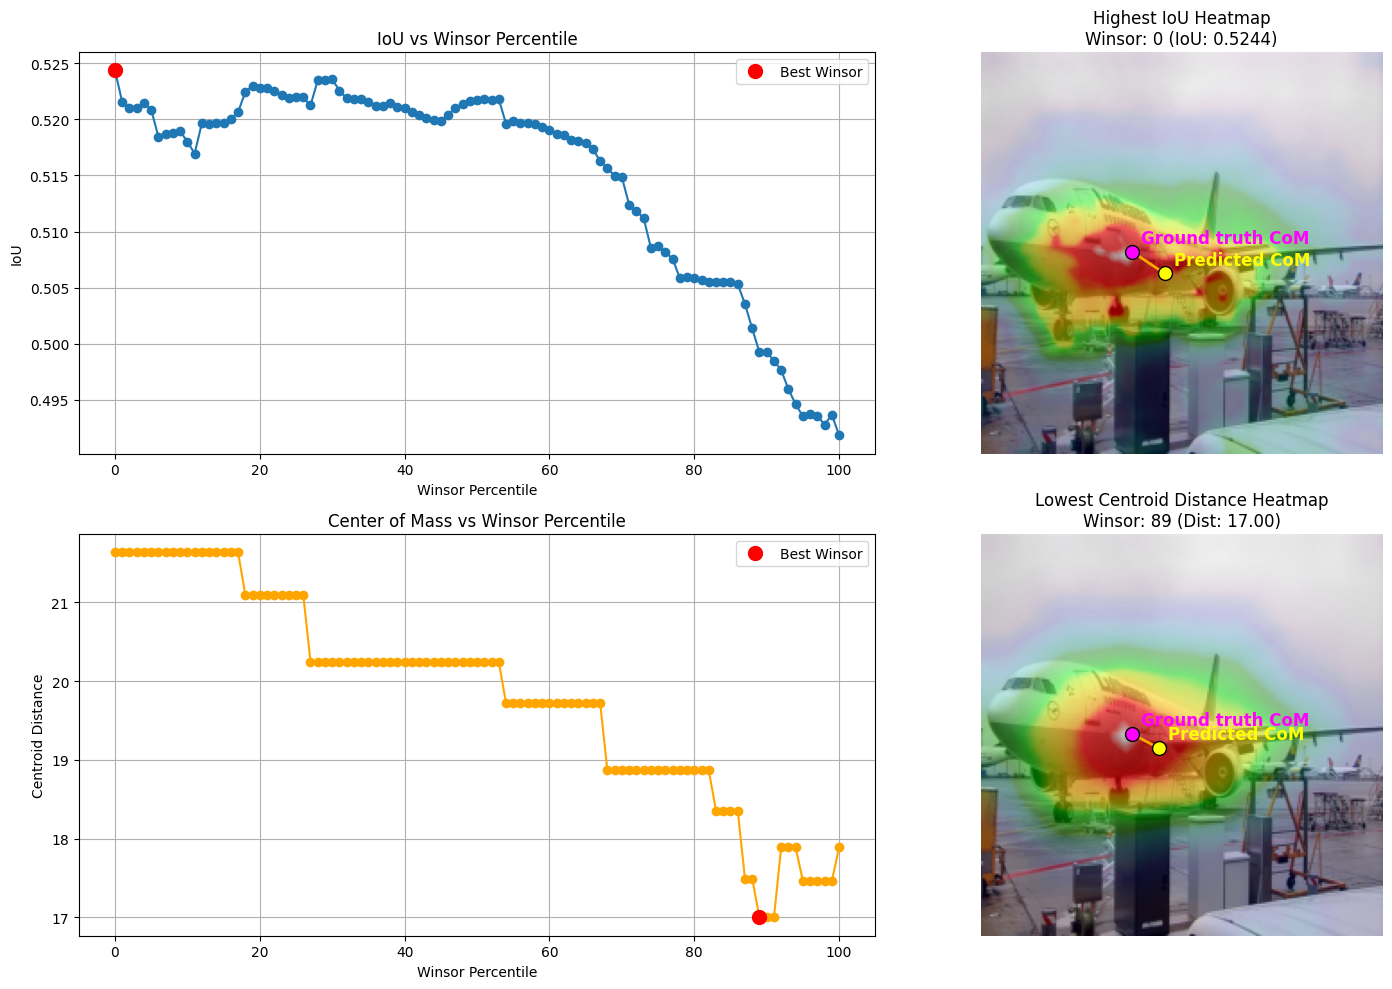

Lowest centroid distance: 17.00 at Winsor Percentile: 89


In [10]:
save_path = "./outputs/iou_centroid_analysis.png"


input_tensor, label, one_hot, indx= dataset[image_name]

model = model.to(device)
model.storage.clear()  # Ensure storage is clear
model._unregister_hooks()  # Remove any existing hooks
model._register_hooks()    # Register fresh hooks

model.eval()
with torch.no_grad():
    output = model(input_tensor.to(device).unsqueeze(0))
predicted_class = torch.argmax(output).item()
sample_label = torch.argmax(one_hot).item()
print(f"Predicted class: {predicted_class}")
print(f"predicted class name:{classes[predicted_class]}")
# print(f"Sample label: {sample_label}")
# raise ValueError("Stop here")
# print(labels)

# print(f"actual label: {labels[sample_label]}")
# print(f"predicted label: {labels[predicted_class]}")

model.storage.clear()  # Ensure storage is clear
model._unregister_hooks()  # Remove any existing hooks
model._register_hooks()    # Register fresh hooks
print(f"input tensor shape: {input_tensor.unsqueeze(0).shape}")
print(f"label shape: {label.shape}")
# use get_gradcams_and_importance
stacked_gradcam, gradcams, importance_tensor = model.get_gradcams_and_importance(input_tensor.to(device).unsqueeze(0),
                                                                                 predicted_class, layer_names,
                                                                                 gradient_aggregation_method,
                                                                                 layer_aggregation_method, stack_relu,
                                                                                 interpolation_mode=interpolation_mode)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
unnormalized_image = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
unnormalized_image = std * unnormalized_image + mean
unnormalized_image = np.clip(unnormalized_image, 0, 1)

final_layer_gradcam = gradcams[-1].unsqueeze(0).unsqueeze(0)
# interpolate the final layer gradcam to the size of the input tensor
final_layer_gradcam_interpolated = F.interpolate(final_layer_gradcam, size=input_tensor.shape[1:], mode=interpolation_mode).squeeze(0).squeeze(0)


averaged_gradcam = torch.mean(stacked_gradcam, dim=0)
# interpolate the averaged gradcam to the size of the input tensor
averaged_gradcam_interpolated = F.interpolate(averaged_gradcam.unsqueeze(0).unsqueeze(0),
                                                size=input_tensor.shape[1:], mode=interpolation_mode).squeeze(0).squeeze(0)


new_label = torch.where(
    (label[:,:,0] > 0) | (label[:,:,1] > 0) | (label[:,:,2] > 0),
    torch.tensor(1, dtype=torch.uint8),
    torch.tensor(0, dtype=torch.uint8)
)

centroid_mask = find_heatmap_centroid(new_label.squeeze().cpu().numpy())


winsor_dist = []
winsor_ious = []
best_centroid_pred_iou = None
best_centroid_pred_dist = None
highest_iou = 0
best_winsor = 0
highest_iou_heatmap = -np.inf

lowest_dist = np.inf
best_dist_winsor = 0
best_dist_heatmap = None

# Generate GradCAMs for different winsor percentiles and calculate IoU and centroid distance
for winsor in np.arange(0, 101, 1):
    winsor_gradcam, _ = model.winsorize_stacked_gradcam(
        input_tensor.unsqueeze(0), stacked_gradcam,
        importance_tensor, 
        interpolation_mode=interpolation_mode, 
        winsor_percentile=winsor
    )
    # Create a colored heatmap
    heatmap = create_colored_heatmap(
        winsor_gradcam, size=input_tensor.shape[1:],
        colormap=map_color, 
        op_multiplier=map_opacity_multiplier,
        interpolation_mode=interpolation_mode
    )
    
    # print(label.shape)# (3, 224, 224)
    # needs to be (224, 224, 3)
    # Calculate IoU between prediction and ground truth
    # print(f"winsor_gradcam shape: {winsor_gradcam.shape}, label shape: {label.permute(2, 0, 1).shape}, input_tensor shape: {input_tensor.squeeze().shape}")
    iou = calculate_iou(winsor_gradcam, label.permute(2, 0, 1), input_tensor.squeeze(), interpolation_mode)
    winsor_ious.append((winsor, iou))
    if iou > highest_iou:
        highest_iou = iou
        best_winsor = winsor
        highest_iou_heatmap = heatmap
        best_centroid_pred_iou = find_heatmap_centroid(winsor_gradcam.squeeze().cpu().numpy())

    dist_winsor = calculate_centroid_distance(winsor_gradcam.squeeze(), centroid_mask)
    winsor_dist.append((winsor, dist_winsor))
    if dist_winsor < lowest_dist:
        lowest_dist = dist_winsor
        best_dist_winsor = winsor
        best_dist_heatmap = heatmap
        best_centroid_pred_dist = find_heatmap_centroid(winsor_gradcam.squeeze().cpu().numpy())

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# IoU vs Winsor Percentile
axs[0, 0].plot([x[0] for x in winsor_ious], [x[1] for x in winsor_ious], marker='o')
# Highlight the best winsor IoU point in red
axs[0, 0].plot(best_winsor, highest_iou, 'ro', markersize=10, label='Best Winsor')
axs[0, 0].set_title('IoU vs Winsor Percentile')
axs[0, 0].set_xlabel('Winsor Percentile')
axs[0, 0].set_ylabel('IoU')
axs[0, 0].grid()
axs[0, 0].legend()

# Show the highest IoU heatmap
axs[0, 1].imshow(unnormalized_image)
axs[0, 1].imshow(highest_iou_heatmap)
axs[0, 1].set_title(f'Highest IoU Heatmap\nWinsor: {best_winsor} (IoU: {highest_iou:.4f})')
axs[0, 1].scatter(*best_centroid_pred_iou, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
axs[0, 1].text(best_centroid_pred_iou[0]+5, best_centroid_pred_iou[1]-5, "Predicted CoM", color='yellow', fontsize=12, weight='bold', zorder=4)

axs[0, 1].scatter(*centroid_mask, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
axs[0, 1].text(centroid_mask[0]+5, centroid_mask[1]-5, "Ground truth CoM", color='magenta', fontsize=12, weight='bold', zorder=4)

axs[0, 1].plot([best_centroid_pred_iou[0], centroid_mask[0]], [best_centroid_pred_iou[1], centroid_mask[1]], color='orange', linewidth=2, zorder=2)
axs[0, 1].axis('off')

# Centroid Distance vs Winsor Percentile
axs[1, 0].plot([x[0] for x in winsor_dist], [x[1] for x in winsor_dist], marker='o', color='orange')
# Highlight the best centroid distance point in red
axs[1, 0].plot(best_dist_winsor, lowest_dist, 'ro', markersize=10, label='Best Winsor')
axs[1, 0].set_title('Center of Mass vs Winsor Percentile')
axs[1, 0].set_xlabel('Winsor Percentile')
axs[1, 0].set_ylabel('Centroid Distance')
axs[1, 0].grid()
axs[1, 0].legend()

# Show the lowest centroid distance heatmap
axs[1, 1].imshow(unnormalized_image)
axs[1, 1].imshow(best_dist_heatmap)
axs[1, 1].set_title(f'Lowest Centroid Distance Heatmap\nWinsor: {best_dist_winsor} (Dist: {lowest_dist:.2f})')
axs[1, 1].scatter(*best_centroid_pred_dist, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
axs[1, 1].text(best_centroid_pred_dist[0]+5, best_centroid_pred_dist[1]-5, "Predicted CoM", color='yellow', fontsize=12, weight='bold', zorder=4)
axs[1, 1].scatter(*centroid_mask, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
axs[1, 1].text(centroid_mask[0]+5, centroid_mask[1]-5, "Ground truth CoM", color='magenta', fontsize=12, weight='bold', zorder=4)
axs[1, 1].plot([best_centroid_pred_dist[0], centroid_mask[0]], [best_centroid_pred_dist[1], centroid_mask[1]], color='orange', linewidth=2, zorder=2)
axs[1, 1].axis('off')

# save the figure
plt.savefig(save_path)

plt.tight_layout()
plt.show()
print(f"Lowest centroid distance: {lowest_dist:.2f} at Winsor Percentile: {best_dist_winsor}")




#### Generating a gif to show the difference in visualizations

In [11]:
winsor_gif_name = "./outputs/PVOC_p_range.gif"
temp_dir = "./temp"

Predicted class: 0
predicted class name:aeroplane
actual class: aeroplane


Creating GIF: 100%|████████████████████████████████████████████| 101/101 [00:08<00:00, 11.32it/s]


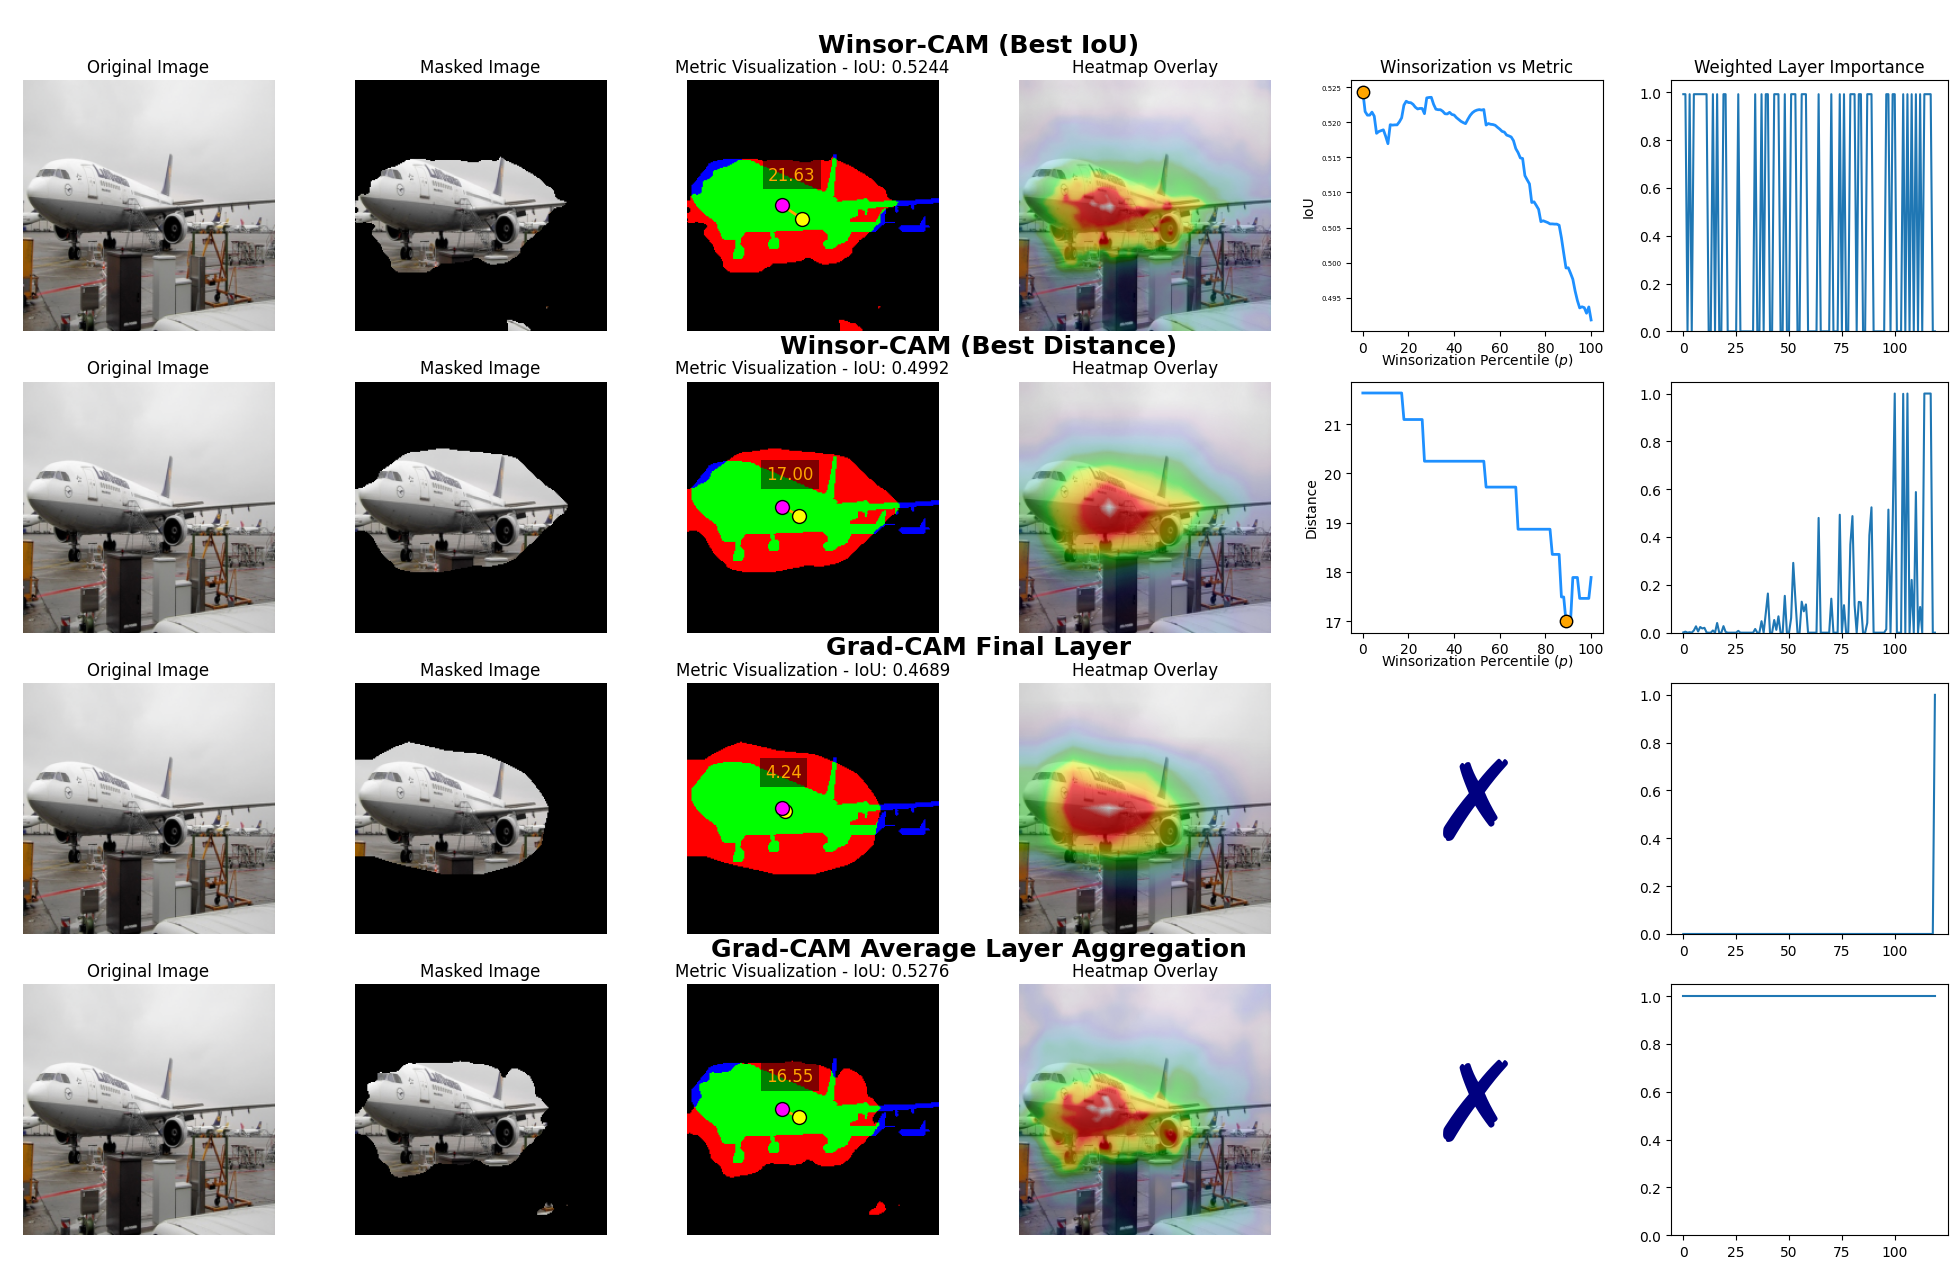

In [12]:
def generate_winsorcam_gif(model, dataset, index, class_index, layer_names,
                         gradient_aggregation_method,
                         layer_aggregation_method, stack_relu, 
                         interpolation_mode='nearest',
                         temp_dir="temp", gif_name="gradcam.gif", labels=None,
                         map_color="Reds", map_opacity_multiplier=1.,
                         needed_class=None, winsor_range=np.arange(0, 101, 10)):
    """
    Generate a GradCAM GIF for different winsor percentiles.

    Args:
        model: The model to generate GradCAMs from
        dataset: The dataset to generate GradCAMs for
        index: The index of the image in the dataset
        class_index: The index of the class to generate
        layer_names: The names of the layers to generate GradCAMs for
        gradient_aggregation_method: The method to aggregate gradients
        stack_aggregation_method: The method to aggregate stacked GradCAMs
        layer_aggregation_method: The method to aggregate layer GradCAMs
        stack_relu: Whether to apply ReLU to stacked GradCAMs
        interpolation_mode: The interpolation mode for resizing
        temp_dir: The temporary directory to store images
        gif_name: The name of the output
    """
    
    # Create a temporary directory to store the images
    os.makedirs(temp_dir, exist_ok=True)


    input_tensor, label, one_hot, cls = dataset[index]
    input_tensor = input_tensor.unsqueeze(0)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnormalized_image = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    unnormalized_image = std * unnormalized_image + mean
    unnormalized_image = np.clip(unnormalized_image, 0, 1)

    model.to(device)
    input_tensor = input_tensor.to(device)
    
    # sample_label = torch.argmax(one_hot).item()
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    predicted_class = torch.argmax(output).item()
    print(f"Predicted class: {predicted_class}")
    print(f"predicted class name:{classes[predicted_class]}")
    # using argmax on the one hot get the actual class
    print(f"actual class: {cls}")
    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks
    stacked_gradcam, gradcams, importance_tensor = model.get_gradcams_and_importance(input_tensor.to(device),
                                                        predicted_class, layer_names,
                                                        gradient_aggregation_method,
                                                        layer_aggregation_method, stack_relu,
                                                        interpolation_mode=interpolation_mode)
    model.storage.clear()  # Ensure storage is clear

    avg_agg_gradcam = torch.mean(stacked_gradcam, dim=0, keepdim=True)
    # now interpolate the avg_agg_gradcam to the size of the input_tensor
    avg_agg_gradcam = F.interpolate(avg_agg_gradcam.unsqueeze(0),
                                    size=input_tensor.shape[2:], 
                                    mode=interpolation_mode).squeeze()
    # now do the same for the final layer gradcam
    final_layer_gradcam = gradcams[-1]
    final_layer_gradcam = F.interpolate(final_layer_gradcam.unsqueeze(0).unsqueeze(0),
                                    size=input_tensor.shape[2:], 
                                    mode=interpolation_mode).squeeze()
    # print(f"final layer gradcam shape: {final_layer_gradcam.shape}")
    # raise ValueError("Stop here")

    # now where there exists something that is not [0,0,0] make it 1 and where it is [0,0,0] make it 0
    label_bin = torch.where(
        (label[:,:,0] > 0) | (label[:,:,1] > 0) | (label[:,:,2] > 0),
        torch.tensor(1, dtype=torch.uint8),
        torch.tensor(0, dtype=torch.uint8)
    )

    # now find the centroid of the label_bin

    centroid_gt = find_heatmap_centroid(label_bin.squeeze().cpu())

    glob_iou = []
    glob_dist = []
    best_winsor_iou = 0
    best_norm_grad_iou = None
    best_winsor_dist = np.inf
    best_norm_grad_dist = None
    best_iou = 0
    best_dist = np.inf
    dists = {}
    ious = {}
    for winsor in tqdm(winsor_range, desc="Generating Winsor_CAMs", unit="winsor"):
        winsor_gradcam, grads = model.winsorize_stacked_gradcam(input_tensor, stacked_gradcam,
                                                       importance_tensor, 
                                                       interpolation_mode=interpolation_mode, 
                                                       winsor_percentile=winsor)

        norm_grads = (grads - grads.min()) / (grads.max() - grads.min() + 1e-8)
        glob_iou.append(calculate_iou(winsor_gradcam, label.permute(2, 0, 1), input_tensor, interpolation_mode))
        mask_centroid = find_heatmap_centroid(winsor_gradcam.squeeze())
        centroid_dist = np.linalg.norm(np.array(mask_centroid) - np.array(centroid_gt))
        glob_dist.append(centroid_dist)
        if glob_dist[-1] < best_dist:
            best_dist = glob_dist[-1]
            best_winsor_dist = winsor
            best_norm_grad_dist = norm_grads
        if glob_iou[-1] > best_iou:
            best_iou = glob_iou[-1]
            best_winsor_iou = winsor
            best_norm_grad_iou = norm_grads
            
        dists[winsor] = centroid_dist
        ious[winsor] = glob_iou[-1]


        
    best_mask_iou = None
    best_image_iou = None
    best_winsor_gradcam_iou = None
    best_mask_dist = None
    best_image_dist = None
    best_winsor_gradcam_dist = None

    plt.ioff()  # Turn off interactive mode to avoid showing plots immediately
    # Generate GradCAMs for different winsor percentiles
    for winsor in tqdm(winsor_range, desc="Generating Winsor_CAMs", unit="winsor"):
        winsor_gradcam, grads = model.winsorize_stacked_gradcam(input_tensor, stacked_gradcam, 
                                                       importance_tensor, 
                                                       interpolation_mode=interpolation_mode, 
                                                       winsor_percentile=winsor)
        
        # nomalize the grads between 0 and 1
        norm_grads = (grads - grads.min()) / (grads.max() - grads.min() + 1e-8)


        # i need the mask of the stacked gradcam
        mask_of_winsor = make_binary_mask(winsor_gradcam.squeeze())

        # use new_label as the ground truth mask
        binary_mask = label_bin

        # now that I have the binary mask and a mask of the winsor gradcam I want to visualize the iou
        colored_image = visualize_mask_iou(mask_of_winsor, binary_mask)

        # calculate_iou the iou using the intersection and the union
        intersection = torch.logical_and(torch.tensor(mask_of_winsor), binary_mask)
        union = torch.logical_or(torch.tensor(mask_of_winsor), binary_mask)
        iou = intersection.sum() / union.sum() if union.sum() > 0 else 0

        # calculate_iou the iou using the intersection and the union
        union = torch.logical_or(torch.tensor(mask_of_winsor), binary_mask)
        iou = intersection.sum() / union.sum() if union.sum() > 0 else 0

        if winsor == best_winsor_iou:
            best_winsor_gradcam_iou = winsor_gradcam
            best_mask_iou = mask_of_winsor
            best_colored_image_iou = colored_image

        if winsor == best_winsor_dist:
            best_winsor_gradcam_dist = winsor_gradcam
            best_mask_dist = mask_of_winsor
            best_colored_image_dist = colored_image

            

        fig, ax = plt.subplots(4, 6, figsize=(25, 15), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})

        # Set row titles that are properly aligned with their rows
        row_titles = [
            "Winsor-CAM (Best IoU)",
            "Winsor-CAM (Best Distance)",
            "Grad-CAM Final Layer",
            "Grad-CAM Average Layer Aggregation"
        ]

        for i, title in enumerate(row_titles):
            # Get position of first subplot in the row
            pos = ax[i, 0].get_position()
            # Calculate position for title: same width as row, small height, just above the row
            title_ax = fig.add_axes([pos.x0, pos.y1, ax[i, -1].get_position().x1 - pos.x0, 0.0475])
            title_ax.axis('off')
            # Use plain text instead of LaTeX underline to avoid ParseFatalException
            title_ax.text(0.5, 0.5, f"{title}", ha='center', va='center', fontsize=18, fontweight='bold')
        # First row
        ax[0, 0].imshow(unnormalized_image)
        ax[0, 0].axis('off')
        ax[0, 0].set_title("Original Image")

        masked_image = generate_masked_image(unnormalized_image, winsor_gradcam.squeeze())
        ax[0, 1].imshow(masked_image)
        ax[0, 1].axis('off')
        ax[0, 1].set_title("Masked Image")

        # IoU Visualization with centroid and distance annotation
        ax[0, 2].imshow(colored_image)
        centroid_pred_iou = find_heatmap_centroid(winsor_gradcam.squeeze())
        ax[0, 2].scatter(*centroid_pred_iou, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
        ax[0, 2].scatter(*centroid_gt, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
        ax[0, 2].plot([centroid_pred_iou[0], centroid_gt[0]], [centroid_pred_iou[1], centroid_gt[1]], color='orange', linewidth=2, zorder=2)
        dist_iou = np.linalg.norm(np.array(centroid_pred_iou) - np.array(centroid_gt))
        mid_x_iou = (centroid_pred_iou[0] + centroid_gt[0]) / 2
        mid_y_iou = (centroid_pred_iou[1] + centroid_gt[1]) / 2
        ax[0, 2].text(mid_x_iou, mid_y_iou - 25, f"{dist_iou:.2f}", color='orange', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        ax[0, 2].axis('off')
        ax[0, 2].set_title(f"Metric Visualization - IoU: {iou:.4f}")

        ax[0, 3].imshow(unnormalized_image)
        ax[0, 3].imshow(create_colored_heatmap(winsor_gradcam.squeeze(), op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
        ax[0, 3].axis('off')
        ax[0, 3].set_title("Heatmap Overlay")

        ax[0, 4].plot(winsor_range, glob_iou, color='dodgerblue', linewidth=2)
        ax[0, 4].scatter(winsor, ious[winsor], c='red', edgecolors='black', marker='o', s=80, zorder=5)
        ax[0, 4].scatter(best_winsor_iou, best_iou, c='orange', edgecolors='black', marker='o', s=80, zorder=5)
        ax[0, 4].set_xlabel("Winsorization Percentile ($p$)", labelpad=-3)  # Reduce labelpad to decrease space
        ax[0, 4].set_ylabel("IoU")
        ax[0, 4].set_title(f"Winsorization vs Metric")
        # Make y-axis tick numbers smaller
        ax[0, 4].tick_params(axis='y', labelsize=5)

        ax[0, 5].plot(norm_grads.cpu().numpy())
        ax[0, 5].set_ylim(0, 1.05)
        ax[0, 5].set_title("Weighted Layer Importance")
        

        # Second row
        ax[1, 0].imshow(unnormalized_image)
        ax[1, 0].axis('off')
        ax[1, 0].set_title("Original Image")

        masked_image = generate_masked_image(unnormalized_image, winsor_gradcam.squeeze())
        ax[1, 1].imshow(masked_image)
        ax[1, 1].axis('off')
        ax[1, 1].set_title("Masked Image")

        ax[1, 2].imshow(colored_image)
        centroid_pred = find_heatmap_centroid(winsor_gradcam.squeeze())
        ax[1, 2].scatter(*centroid_pred, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
        ax[1, 2].scatter(*centroid_gt, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
        ax[1, 2].plot([centroid_pred[0], centroid_gt[0]], [centroid_pred[1], centroid_gt[1]], color='orange', linewidth=2, zorder=2)
        dist = np.linalg.norm(np.array(centroid_pred) - np.array(centroid_gt))
        mid_x = (centroid_pred[0] + centroid_gt[0]) / 2
        mid_y = (centroid_pred[1] + centroid_gt[1]) / 2
        ax[1, 2].text(mid_x, mid_y - 25, f"{dist:.2f}", color='orange', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        ax[1, 2].axis('off')
        iou = calculate_iou(winsor_gradcam, label.permute(2, 0, 1), input_tensor, interpolation_mode)


        ax[1, 2].set_title(f"Metric Visualization - IoU: {iou:.4f}")

        ax[1, 3].imshow(unnormalized_image)
        ax[1, 3].imshow(create_colored_heatmap(winsor_gradcam.squeeze(), op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
        ax[1, 3].axis('off')
        ax[1, 3].set_title("Heatmap Overlay")

        ax[1, 4].plot(winsor_range, glob_dist, color='dodgerblue', linewidth=2)
        ax[1, 4].scatter(winsor, dists[winsor], c='red', edgecolors='black', marker='o', s=80, zorder=5)
        ax[1, 4].scatter(best_winsor_dist, best_dist, c='orange', edgecolors='black', marker='o', s=80, zorder=5)
        ax[1, 4].set_xlabel("Winsorization Percentile ($p$)", labelpad=-3)
        ax[1, 4].set_ylabel("Distance")
        ax[1, 5].plot(norm_grads.cpu().numpy())
        ax[1, 5].set_ylim(0, 1.05)

        # Third row: Final layer GradCAM
        for j in range(5):
            ax[2, j].axis('off')


        ax[2, 0].imshow(unnormalized_image)
        ax[2, 0].axis('off')
        ax[2, 0].set_title("Original Image")

        ax[2, 1].imshow(unnormalized_image)
        masked_image = generate_masked_image(unnormalized_image, final_layer_gradcam)
        ax[2, 1].imshow(masked_image)
        ax[2, 1].axis('off')
        ax[2, 1].set_title("Masked Image")

        final_layer_mask = make_binary_mask(final_layer_gradcam)
        colored_image_of_final_layer = visualize_mask_iou(final_layer_mask, label_bin)
        intersection_final = torch.logical_and(torch.tensor(final_layer_mask), label_bin)
        union_final = torch.logical_or(torch.tensor(final_layer_mask), label_bin)
        iou_final = intersection_final.sum().float() / union_final.sum().float() if union_final.sum() > 0 else 0.0
        ax[2, 2].imshow(colored_image_of_final_layer)
        centroid_pred_final = find_heatmap_centroid(final_layer_gradcam)
        centroid_gt_final = find_heatmap_centroid(label_bin.squeeze().cpu())
        ax[2, 2].scatter(*centroid_pred_final, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
        ax[2, 2].scatter(*centroid_gt_final, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
        ax[2, 2].plot([centroid_pred_final[0], centroid_gt_final[0]], [centroid_pred_final[1], centroid_gt_final[1]], color='orange', linewidth=2, zorder=2)
        dist_final = np.linalg.norm(np.array(centroid_pred_final) - np.array(centroid_gt_final))
        mid_x_final = (centroid_pred_final[0] + centroid_gt_final[0]) / 2
        mid_y_final = (centroid_pred_final[1] + centroid_gt_final[1]) / 2
        ax[2, 2].text(mid_x_final, mid_y_final - 25, f"{dist_final:.2f}", color='orange', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        ax[2, 2].axis('off')
        ax[2, 2].set_title(f"Metric Visualization - IoU: {iou_final:.4f}")

        ax[2, 3].imshow(unnormalized_image)
        ax[2, 3].imshow(create_colored_heatmap(final_layer_gradcam, op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
        ax[2, 3].axis('off')
        ax[2, 3].set_title("Heatmap Overlay")
        # as there is no plot for the final layer gradcam, we need to put a big red X so that the grid is complete
        ax[2, 4].axis('off')
        ax[2, 4].text(0.5, 0.5, "✗", fontsize=80, ha='center', va='center', color='navy', fontweight='bold')
        # make a line that is 0 until the length of norm_grads
        line = [0] * (len(norm_grads)-1)
        line.append(1)  # Add a final point to make it straight at 1
        ax[2, 5].plot(line)
        ax[2, 5].set_ylim(0, 1.05)


        # Fourth row: Average aggregated GradCAM
        for j in range(5):
            ax[3, j].axis('off')

        ax[3, 0].imshow(unnormalized_image)
        ax[3, 0].axis('off')
        ax[3, 0].set_title("Original Image")

        ax[3, 1].imshow(unnormalized_image)
        masked_image_avg = generate_masked_image(unnormalized_image, avg_agg_gradcam)
        ax[3, 1].imshow(masked_image_avg)
        ax[3, 1].axis('off')
        ax[3, 1].set_title("Masked Image")

        avg_agg_mask = make_binary_mask(avg_agg_gradcam)
        colored_image_avg_agg = visualize_mask_iou(avg_agg_mask, label_bin)
        intersection_avg = torch.logical_and(torch.tensor(avg_agg_mask), label_bin)
        union_avg = torch.logical_or(torch.tensor(avg_agg_mask), label_bin)
        iou_avg = intersection_avg.sum().float() / union_avg.sum().float() if union_avg.sum() > 0 else 0.0
        ax[3, 2].imshow(colored_image_avg_agg)
        centroid_pred_avg = find_heatmap_centroid(avg_agg_gradcam)
        centroid_gt_avg = find_heatmap_centroid(label_bin.squeeze().cpu())
        ax[3, 2].plot([centroid_pred_avg[0], centroid_gt_avg[0]], [centroid_pred_avg[1], centroid_gt_avg[1]], color='orange', linewidth=2, zorder=2)
        ax[3, 2].scatter(*centroid_pred_avg, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
        ax[3, 2].scatter(*centroid_gt_avg, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
        dist_avg = np.linalg.norm(np.array(centroid_pred_avg) - np.array(centroid_gt_avg))
        mid_x_avg = (centroid_pred_avg[0] + centroid_gt_avg[0]) / 2
        mid_y_avg = (centroid_pred_avg[1] + centroid_gt_avg[1]) / 2
        ax[3, 2].text(mid_x_avg, mid_y_avg - 25, f"{dist_avg:.2f}", color='orange', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        ax[3, 2].axis('off')
        ax[3, 2].set_title(f"Metric Visualization - IoU: {iou_avg:.4f}")


        ax[3, 3].imshow(unnormalized_image)
        ax[3, 3].imshow(create_colored_heatmap(avg_agg_gradcam, op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
        ax[3, 3].axis('off')
        ax[3, 3].set_title("Heatmap Overlay")

        ax[3, 4].axis('off')
        ax[3, 4].text(0.5, 0.5, "✗", fontsize=80, ha='center', va='center', color='navy', fontweight='bold')
        # put in ax[3, 5] a line that is straight at 1 and there are len(norm_grads)points
        #first make a list of 1s that is len(norm_grads)
        ax[3, 5].plot([1] * len(norm_grads))
        ax[3, 5].set_ylim(0, 1.05)

        # Make all axes square for images only (not for plots)
        for i in range(4):
            for j in range(5):
                if j < 4:
                    ax[i, j].set_aspect('equal')
                else:
                    ax[i, j].set_box_aspect(1)

        plt.savefig(os.path.join(temp_dir, f"{winsor}.png"))
        plt.close(fig)
    plt.ion()



    # Create a GIF from the saved images
    with imageio.get_writer(gif_name, mode='I', duration=1000, loop=0) as writer:
        for winsor in tqdm(winsor_range, desc="Creating GIF"):
            image_file = os.path.join(temp_dir, f"{winsor}.png")
            if os.path.exists(image_file):
                image = imageio.imread(image_file)
                writer.append_data(image)
                del image  # Free memory immediately

    # Remove the temporary directory
    shutil.rmtree(temp_dir)
    # imshow(best_winsor_gradcam_iou.cpu())
    # show()
    # imshow(avg_agg_gradcam.cpu())
    # show()
    # imshow(final_layer_gradcam.cpu())
    # show()
    # raise ValueError("Stop here")

    # make a figure that shows the unnormalized_image best_winsor_gradcam mask_of_winsor best_colored_image, best_mask, and the plot(winsor_range, glob_iou) with dot
    fig, ax = plt.subplots(4, 6, figsize=(25, 15), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})

    # Set row titles that are properly aligned with their rows
    row_titles = [
        "Winsor-CAM (Best IoU)",
        "Winsor-CAM (Best Distance)",
        "Grad-CAM Final Layer",
        "Grad-CAM Average Layer Aggregation"
    ]

    for i, title in enumerate(row_titles):
        # Get position of first subplot in the row
        pos = ax[i, 0].get_position()
        # Calculate position for title: same width as row, small height, just above the row
        title_ax = fig.add_axes([pos.x0, pos.y1, ax[i, -1].get_position().x1 - pos.x0, 0.0475])
        title_ax.axis('off')
        # Use plain text instead of LaTeX underline to avoid ParseFatalException
        title_ax.text(0.5, 0.5, f"{title}", ha='center', va='center', fontsize=18, fontweight='bold')
    # First row
    ax[0, 0].imshow(unnormalized_image)
    ax[0, 0].axis('off')
    ax[0, 0].set_title("Original Image")

    masked_image = generate_masked_image(unnormalized_image, best_winsor_gradcam_iou.squeeze())
    ax[0, 1].imshow(masked_image)
    ax[0, 1].axis('off')
    ax[0, 1].set_title("Masked Image")

    # IoU Visualization with centroid and distance annotation
    ax[0, 2].imshow(best_colored_image_iou)
    centroid_pred_iou = find_heatmap_centroid(best_winsor_gradcam_iou.squeeze())
    ax[0, 2].scatter(*centroid_pred_iou, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
    ax[0, 2].scatter(*centroid_gt, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
    ax[0, 2].plot([centroid_pred_iou[0], centroid_gt[0]], [centroid_pred_iou[1], centroid_gt[1]], color='orange', linewidth=2, zorder=2)
    dist_iou = np.linalg.norm(np.array(centroid_pred_iou) - np.array(centroid_gt))
    mid_x_iou = (centroid_pred_iou[0] + centroid_gt[0]) / 2
    mid_y_iou = (centroid_pred_iou[1] + centroid_gt[1]) / 2
    ax[0, 2].text(mid_x_iou, mid_y_iou - 25, f"{dist_iou:.2f}", color='orange', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    ax[0, 2].axis('off')
    ax[0, 2].set_title(f"Metric Visualization - IoU: {best_iou:.4f}")

    ax[0, 3].imshow(unnormalized_image)
    ax[0, 3].imshow(create_colored_heatmap(best_winsor_gradcam_iou.squeeze(), op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
    ax[0, 3].axis('off')
    ax[0, 3].set_title("Heatmap Overlay")

    ax[0, 4].plot(winsor_range, glob_iou, color='dodgerblue', linewidth=2)
    ax[0, 4].scatter(best_winsor_iou, best_iou, c='orange', edgecolors='black', marker='o', s=80, zorder=5)
    ax[0, 4].set_xlabel("Winsorization Percentile ($p$)", labelpad=-3)  # Reduce labelpad to decrease space
    ax[0, 4].set_ylabel("IoU")
    ax[0, 4].set_title(f"Winsorization vs Metric")
    # Make y-axis tick numbers smaller
    ax[0, 4].tick_params(axis='y', labelsize=5)
    ax[0, 5].plot(best_norm_grad_iou.cpu().numpy())
    ax[0, 5].set_ylim(0, 1.05)
    ax[0, 5].set_title("Weighted Layer Importance")


    # Second row
    ax[1, 0].imshow(unnormalized_image)
    ax[1, 0].axis('off')
    ax[1, 0].set_title("Original Image")

    masked_image = generate_masked_image(unnormalized_image, best_winsor_gradcam_dist.squeeze())
    ax[1, 1].imshow(masked_image)
    ax[1, 1].axis('off')
    ax[1, 1].set_title("Masked Image")

    ax[1, 2].imshow(best_colored_image_dist)
    centroid_pred = find_heatmap_centroid(best_winsor_gradcam_dist.squeeze())
    ax[1, 2].scatter(*centroid_pred, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
    ax[1, 2].scatter(*centroid_gt, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
    ax[1, 2].plot([centroid_pred[0], centroid_gt[0]], [centroid_pred[1], centroid_gt[1]], color='orange', linewidth=2, zorder=2)
    dist = np.linalg.norm(np.array(centroid_pred) - np.array(centroid_gt))
    mid_x = (centroid_pred[0] + centroid_gt[0]) / 2
    mid_y = (centroid_pred[1] + centroid_gt[1]) / 2
    ax[1, 2].text(mid_x, mid_y - 25, f"{dist:.2f}", color='orange', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    ax[1, 2].axis('off')
    iou = calculate_iou(best_winsor_gradcam_dist, label.permute(2, 0, 1), input_tensor, interpolation_mode)


    ax[1, 2].set_title(f"Metric Visualization - IoU: {iou:.4f}")

    ax[1, 3].imshow(unnormalized_image)
    ax[1, 3].imshow(create_colored_heatmap(best_winsor_gradcam_dist.squeeze(), op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
    ax[1, 3].axis('off')
    ax[1, 3].set_title("Heatmap Overlay")

    ax[1, 4].plot(winsor_range, glob_dist, color='dodgerblue', linewidth=2)
    ax[1, 4].scatter(best_winsor_dist, best_dist, c='orange', edgecolors='black', marker='o', s=80, zorder=5)
    ax[1, 4].set_xlabel("Winsorization Percentile ($p$)", labelpad=-3)
    ax[1, 4].set_ylabel("Distance")
    ax[1, 5].plot(best_norm_grad_dist.cpu().numpy())
    ax[1, 5].set_ylim(0, 1.05)


    # Third row: Final layer GradCAM
    for j in range(5):
        ax[2, j].axis('off')


    ax[2, 0].imshow(unnormalized_image)
    ax[2, 0].axis('off')
    ax[2, 0].set_title("Original Image")

    ax[2, 1].imshow(unnormalized_image)
    masked_image = generate_masked_image(unnormalized_image, final_layer_gradcam)
    ax[2, 1].imshow(masked_image)
    ax[2, 1].axis('off')
    ax[2, 1].set_title("Masked Image")

    final_layer_mask = make_binary_mask(final_layer_gradcam)
    colored_image_of_final_layer = visualize_mask_iou(final_layer_mask, label_bin)
    intersection_final = torch.logical_and(torch.tensor(final_layer_mask), label_bin)
    union_final = torch.logical_or(torch.tensor(final_layer_mask), label_bin)
    iou_final = intersection_final.sum().float() / union_final.sum().float() if union_final.sum() > 0 else 0.0
    ax[2, 2].imshow(colored_image_of_final_layer)
    centroid_pred_final = find_heatmap_centroid(final_layer_gradcam)
    centroid_gt_final = find_heatmap_centroid(label_bin.squeeze().cpu())
    ax[2, 2].scatter(*centroid_pred_final, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
    ax[2, 2].scatter(*centroid_gt_final, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
    ax[2, 2].plot([centroid_pred_final[0], centroid_gt_final[0]], [centroid_pred_final[1], centroid_gt_final[1]], color='orange', linewidth=2, zorder=2)
    dist_final = np.linalg.norm(np.array(centroid_pred_final) - np.array(centroid_gt_final))
    mid_x_final = (centroid_pred_final[0] + centroid_gt_final[0]) / 2
    mid_y_final = (centroid_pred_final[1] + centroid_gt_final[1]) / 2
    ax[2, 2].text(mid_x_final, mid_y_final - 25, f"{dist_final:.2f}", color='orange', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    ax[2, 2].axis('off')
    ax[2, 2].set_title(f"Metric Visualization - IoU: {iou_final:.4f}")

    ax[2, 3].imshow(unnormalized_image)
    ax[2, 3].imshow(create_colored_heatmap(final_layer_gradcam, op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
    ax[2, 3].axis('off')
    ax[2, 3].set_title("Heatmap Overlay")
    # as there is no plot for the final layer gradcam, we need to put a big red X so that the grid is complete
    ax[2, 4].axis('off')
    ax[2, 4].text(0.5, 0.5, "✗", fontsize=80, ha='center', va='center', color='navy', fontweight='bold')
    # make a line that is 0 until the length of norm_grads
    line = [0] * (len(norm_grads)-1)
    line.append(1)  # Add a final point to make it straight at 1
    ax[2, 5].plot(line)
    ax[2, 5].set_ylim(0, 1.05)
    


    # Fourth row: Average aggregated GradCAM
    for j in range(5):
        ax[3, j].axis('off')

    ax[3, 0].imshow(unnormalized_image)
    ax[3, 0].axis('off')
    ax[3, 0].set_title("Original Image")

    ax[3, 1].imshow(unnormalized_image)
    masked_image_avg = generate_masked_image(unnormalized_image, avg_agg_gradcam)
    ax[3, 1].imshow(masked_image_avg)
    ax[3, 1].axis('off')
    ax[3, 1].set_title("Masked Image")

    avg_agg_mask = make_binary_mask(avg_agg_gradcam)
    colored_image_avg_agg = visualize_mask_iou(avg_agg_mask, label_bin)
    intersection_avg = torch.logical_and(torch.tensor(avg_agg_mask), label_bin)
    union_avg = torch.logical_or(torch.tensor(avg_agg_mask), label_bin)
    iou_avg = intersection_avg.sum().float() / union_avg.sum().float() if union_avg.sum() > 0 else 0.0
    ax[3, 2].imshow(colored_image_avg_agg)
    centroid_pred_avg = find_heatmap_centroid(avg_agg_gradcam)
    centroid_gt_avg = find_heatmap_centroid(label_bin.squeeze().cpu())
    ax[3, 2].plot([centroid_pred_avg[0], centroid_gt_avg[0]], [centroid_pred_avg[1], centroid_gt_avg[1]], color='orange', linewidth=2, zorder=2)
    ax[3, 2].scatter(*centroid_pred_avg, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
    ax[3, 2].scatter(*centroid_gt_avg, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
    dist_avg = np.linalg.norm(np.array(centroid_pred_avg) - np.array(centroid_gt_avg))
    mid_x_avg = (centroid_pred_avg[0] + centroid_gt_avg[0]) / 2
    mid_y_avg = (centroid_pred_avg[1] + centroid_gt_avg[1]) / 2
    ax[3, 2].text(mid_x_avg, mid_y_avg - 25, f"{dist_avg:.2f}", color='orange', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    ax[3, 2].axis('off')
    ax[3, 2].set_title(f"Metric Visualization - IoU: {iou_avg:.4f}")


    ax[3, 3].imshow(unnormalized_image)
    ax[3, 3].imshow(create_colored_heatmap(avg_agg_gradcam, op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
    ax[3, 3].axis('off')
    ax[3, 3].set_title("Heatmap Overlay")

    ax[3, 4].axis('off')
    ax[3, 4].text(0.5, 0.5, "✗", fontsize=80, ha='center', va='center', color='navy', fontweight='bold')
    ax[3, 5].plot([1] * len(norm_grads))
    ax[3, 5].set_ylim(0, 1.05)
    
    # Make all axes square for images only (not for plots)
    for i in range(4):
        for j in range(5):
            if j < 4:
                ax[i, j].set_aspect('equal')
            else:
                ax[i, j].set_box_aspect(1)
    # Save the final figure
    # plt.savefig(gif_name, bbox_inches='tight', dpi=400)
    plt.show()

generate_winsorcam_gif(model, dataset, image_name, class_index, layer_names,
                     gradient_aggregation_method,
                     layer_aggregation_method, stack_relu, 
                     interpolation_mode=interpolation_mode,
                     temp_dir="temp", gif_name=winsor_gif_name, labels=classes,
                     map_color=map_color, map_opacity_multiplier=map_opacity_multiplier,
                     needed_class=None, winsor_range=np.arange(0, 101, 1))\
# this may take a bit to run, as the image generation inside the loop is slow
# the step can be ajusted by changing the winsor_range parameter (the step is currently 1)


#### Comparing Winsor-CAM with other methods

Predicted class: 0
predicted class name:aeroplane
actual class: aeroplane


Generating Winsor_CAMs: 100%|██████████████████████████████| 101/101 [00:01<00:00, 88.77winsor/s]


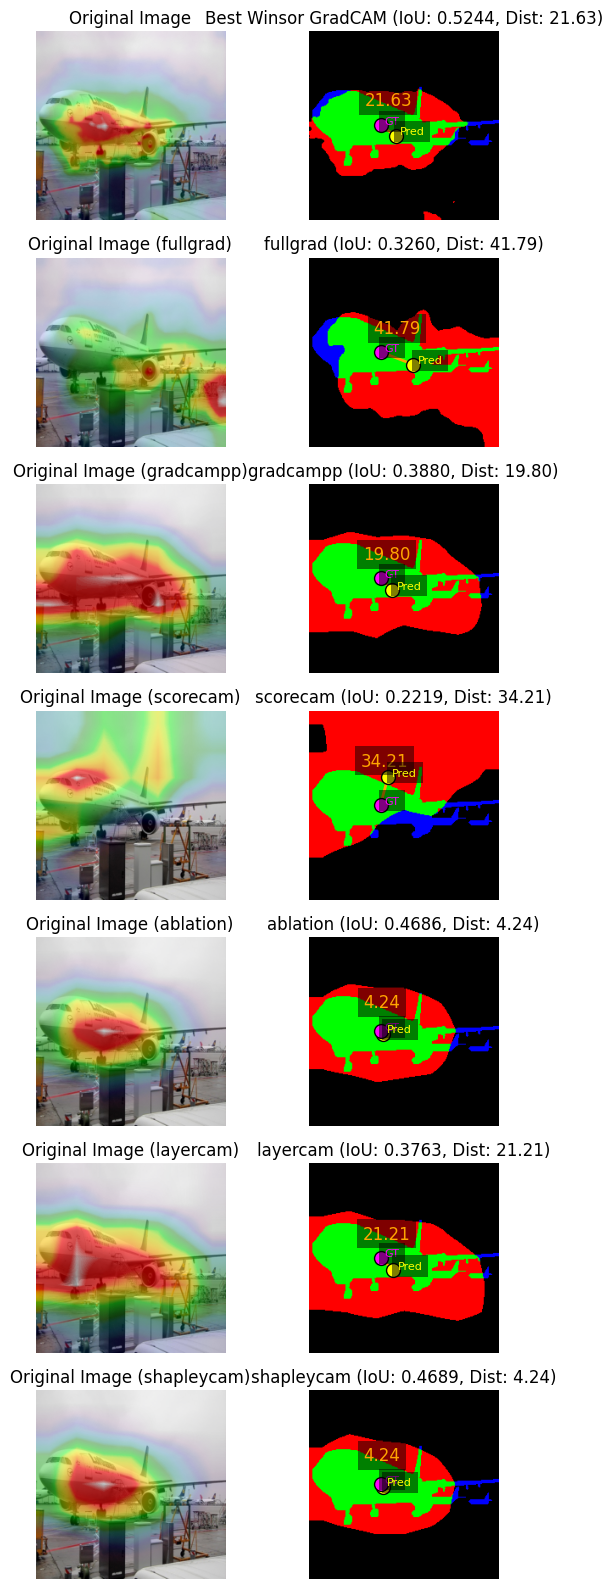

In [13]:
save_path = "./outputs/winsor_comparison.png"

def compare(model, dataset, index, class_index, layer_names,
                         gradient_aggregation_method,
                         layer_aggregation_method, stack_relu, 
                         interpolation_mode='nearest',
                         temp_dir="temp", labels=None,
                         map_color="Reds", map_opacity_multiplier=1.,
                         needed_class=None, winsor_range=np.arange(0, 101, 10),
                         save_path="comparison.png"):

    
    # Create a temporary directory to store the images
    os.makedirs(temp_dir, exist_ok=True)


    input_tensor, label, one_hot, cls = dataset[index]
    input_tensor = input_tensor.unsqueeze(0)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnormalized_image = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    unnormalized_image = std * unnormalized_image + mean
    unnormalized_image = np.clip(unnormalized_image, 0, 1)

    model.to(device)
    input_tensor = input_tensor.to(device)
    
    # sample_label = torch.argmax(one_hot).item()
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    predicted_class = torch.argmax(output).item()
    print(f"Predicted class: {predicted_class}")
    print(f"predicted class name:{classes[predicted_class]}")
    # using argmax on the one hot get the actual class
    print(f"actual class: {cls}")
    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks
    stacked_gradcam, gradcams, importance_tensor = model.get_gradcams_and_importance(input_tensor.to(device),
                                                        predicted_class, layer_names,
                                                        gradient_aggregation_method,
                                                        layer_aggregation_method, stack_relu,
                                                        interpolation_mode=interpolation_mode)
    model.storage.clear()  # Ensure storage is clear

    avg_agg_gradcam = torch.mean(stacked_gradcam, dim=0, keepdim=True)
    # now interpolate the avg_agg_gradcam to the size of the input_tensor
    avg_agg_gradcam = F.interpolate(avg_agg_gradcam.unsqueeze(0),
                                    size=input_tensor.shape[2:], 
                                    mode=interpolation_mode).squeeze()
    # now do the same for the final layer gradcam
    final_layer_gradcam = gradcams[-1]
    final_layer_gradcam = F.interpolate(final_layer_gradcam.unsqueeze(0).unsqueeze(0),
                                    size=input_tensor.shape[2:], 
                                    mode=interpolation_mode).squeeze()
    # print(f"final layer gradcam shape: {final_layer_gradcam.shape}")
    # raise ValueError("Stop here")

    # now where there exists something that is not [0,0,0] make it 1 and where it is [0,0,0] make it 0
    label_bin = torch.where(
        (label[:,:,0] > 0) | (label[:,:,1] > 0) | (label[:,:,2] > 0),
        torch.tensor(1, dtype=torch.uint8),
        torch.tensor(0, dtype=torch.uint8)
    )

    # now find the centroid of the label_bin

    centroid_gt = find_heatmap_centroid(label_bin.squeeze().cpu())

    glob_iou = []
    glob_dist = []
    best_winsor_iou = 0
    best_winsor_dist = np.inf
    best_iou = 0
    best_dist = np.inf
    dists = {}
    ious = {}
    for winsor in tqdm(winsor_range, desc="Generating Winsor_CAMs", unit="winsor"):
        winsor_gradcam, grads = model.winsorize_stacked_gradcam(input_tensor, stacked_gradcam,
                                                       importance_tensor, 
                                                       interpolation_mode=interpolation_mode, 
                                                       winsor_percentile=winsor)
        
        glob_iou.append(calculate_iou(winsor_gradcam, label.permute(2, 0, 1), input_tensor, interpolation_mode))
        mask_centroid = find_heatmap_centroid(winsor_gradcam.squeeze())
        centroid_dist = np.linalg.norm(np.array(mask_centroid) - np.array(centroid_gt))
        glob_dist.append(centroid_dist)
        if glob_dist[-1] < best_dist:
            best_dist = glob_dist[-1]
            best_winsor_dist = winsor
        if glob_iou[-1] > best_iou:
            best_iou = glob_iou[-1]
            best_winsor_iou = winsor
        dists[winsor] = centroid_dist
        ious[winsor] = glob_iou[-1]

    # show the best winsor gradcam
    best_winsor_gradcam_iou, _ = model.winsorize_stacked_gradcam(input_tensor, stacked_gradcam,
                                                       importance_tensor,
                                                       interpolation_mode=interpolation_mode,
                                                       winsor_percentile=best_winsor_iou)
    if inception:
        methods_to_use = ["gradcampp", "scorecam", "ablation", "layercam", "shapleycam"]
    else:
        methods_to_use = ["fullgrad","gradcampp", "scorecam", "ablation", "layercam", "shapleycam"]

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(len(methods_to_use)+1, 2, figsize=(9, 16))

    # Show the unnormalized image on the left
    axes[0,0].imshow(unnormalized_image)
    axes[0,0].set_title("Original Image")
    axes[0,0].axis('off')

    # Show the colored heatmap on the right
    axes[0,0].imshow(create_colored_heatmap(best_winsor_gradcam_iou.squeeze(), op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))
    # Overlay the binary mask IoU visualization
    best_colored_image_iou = visualize_mask_iou(make_binary_mask(best_winsor_gradcam_iou), label_bin)
    axes[0,1].imshow(best_colored_image_iou)

    # Plot centroids and line on the right subplot
    centroid_pred_iou = find_heatmap_centroid(best_winsor_gradcam_iou.squeeze())
    axes[0,1].scatter(*centroid_pred_iou, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
    axes[0,1].scatter(*centroid_gt, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
    axes[0,1].plot([centroid_pred_iou[0], centroid_gt[0]], [centroid_pred_iou[1], centroid_gt[1]], color='orange', linewidth=2, zorder=2)
    dist_iou = np.linalg.norm(np.array(centroid_pred_iou) - np.array(centroid_gt))
    mid_x_iou = (centroid_pred_iou[0] + centroid_gt[0]) / 2
    mid_y_iou = (centroid_pred_iou[1] + centroid_gt[1]) / 2
    axes[0,1].text(mid_x_iou, mid_y_iou - 25, f"{dist_iou:.2f}", color='orange', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    axes[0,1].text(centroid_gt[0] + 5, centroid_gt[1] - 5, "GT", color='magenta', fontsize=8, ha='left',
                 va='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    axes[0,1].text(centroid_pred_iou[0] + 5, centroid_pred_iou[1] - 5, "Pred", color='yellow', fontsize=8, ha='left',
                 va='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    axes[0,1].set_title(f"Best Winsor GradCAM (IoU: {best_iou:.4f}, Dist: {dist_iou:.2f})")
    axes[0,1].axis('off')

    plt.tight_layout()
    # plt.show()


    for i,method in enumerate(methods_to_use, start=1):
        # print(f"Using method: {method}")
        # with cuda_memory_cleanup():
        cam = model.get_cam_comparative(input_tensor.squeeze(), method)
        # Convert to tensor efficiently and ensure proper dtype
        if isinstance(cam, np.ndarray):
            cam = torch.from_numpy(cam).float().to(input_tensor.device)
        else:
            cam = torch.tensor(cam, dtype=torch.float32, device=input_tensor.device)

        iou = calculate_iou(cam.squeeze(), label.permute(2, 0, 1), input_tensor, interpolation_mode)
        dist = calculate_centroid_distance(cam.squeeze(), centroid_gt)

        # # Create a figure with two subplots side by side
        # fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Show the unnormalized image on the left
        axes[i,0].imshow(unnormalized_image)
        axes[i,0].set_title(f"Original Image ({method})")
        axes[i,0].axis('off')
        cam = cam.cpu()
        # Show the colored heatmap on the left
        axes[i,0].imshow(create_colored_heatmap(cam.squeeze(), op_multiplier=map_opacity_multiplier, colormap=map_color, interpolation_mode=interpolation_mode))

        # Overlay the binary mask IoU visualization on the right
        colored_image = visualize_mask_iou(make_binary_mask(cam.squeeze()), label_bin)
        axes[i,1].imshow(colored_image)

        # Plot centroids and line on the right subplot
        centroid_pred_iou = find_heatmap_centroid(cam.squeeze())
        axes[i,1].scatter(*centroid_pred_iou, color='yellow', marker='o', edgecolors='black', s=100, zorder=3)
        axes[i,1].scatter(*centroid_gt, color='magenta', marker='o', edgecolors='black', s=100, zorder=3)
        axes[i,1].plot([centroid_pred_iou[0], centroid_gt[0]], [centroid_pred_iou[1], centroid_gt[1]], color='orange', linewidth=2, zorder=2)
        dist_iou = np.linalg.norm(np.array(centroid_pred_iou) - np.array(centroid_gt))
        mid_x_iou = (centroid_pred_iou[0] + centroid_gt[0]) / 2
        mid_y_iou = (centroid_pred_iou[1] + centroid_gt[1]) / 2
        axes[i,1].text(mid_x_iou, mid_y_iou - 25, f"{dist_iou:.2f}", color='orange', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        axes[i,1].text(centroid_gt[0] + 5, centroid_gt[1] - 5, "GT", color='magenta', fontsize=8, ha='left',
                va='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        axes[i,1].text(centroid_pred_iou[0] + 5, centroid_pred_iou[1] - 5, "Pred", color='yellow', fontsize=8, ha='left',
                va='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        axes[i,1].set_title(f"{method} (IoU: {iou:.4f}, Dist: {dist_iou:.2f})")
        axes[i,1].axis('off')

        plt.tight_layout()

        
        # if other_comparative_ious.get(method) is None:
        #     other_comparative_ious[method] = []
        # if other_comparative_dists.get(method) is None:
        #     other_comparative_dists[method] = []
        # other_comparative_ious[method].append((iou, correct))
        # other_comparative_dists[method].append((dist, correct))
        del cam
    
    plt.tight_layout()
    # save the figure
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
        
compare(model, dataset, image_name, class_index, layer_names,
                     gradient_aggregation_method,
                     layer_aggregation_method, stack_relu, 
                     interpolation_mode=interpolation_mode,
                     temp_dir="temp", labels=classes,
                     map_color=map_color, map_opacity_multiplier=map_opacity_multiplier,
                     needed_class=None, winsor_range=np.arange(0, 101, 1),
                     save_path=save_path)